# Bayesian workflow for usage of pymdp (active inference) models with PyBefit

*Authors: Dimitrije Marković & Riddhi J. Pitliya*

He we will illustrate integration of the [pymdp](https://github.com/infer-actively/pymdp) package with PyBefit. As an example we will use an experimental dataset collected using the agency task. The task and the data we are using here for the illustration have been [published](https://osf.io/preprints/osf/ckfrt) at the
[IWAI 2024](https://iwaiworkshop.github.io/) conference. The notebook that illustrate the exact workflow used in the published results can be found [here](https://github.com/riddhipits/pybefit/blob/main/examples/pymdp/simulating_and_fitting_agency_task_IWAI.ipynb). This notebook might deviate from that workflow as it main purpose is to showcase various aspects of pymdp-PyBefit integration, and a generic Bayesian workflow made possible with this integration. 

## Task description
The agency task is a free-operant paradigm assessing participants' perception of agency for themselves and another (simulated) agent.

## Task Structure
At every trial participants either press or do not press a button. Simulated agent presses the button randomly 50% of the time (unknown to participants). Outcomes (filled or outlined shape) appear based on actions. Participants are told to maximise filled shape occurrences while learning action-outcome contingencies for both agents. The entire experiment is split on 24 trials per block; At the end of the block participants rate perceived control using a -10 to 10 scale.

Each block is assigned to one (randomly selected) out of five experimental conditions:

 - Zero: Neither agent has control.
 - Self Positive (SP): Participant has positive control.
 - Self Negative (SN): Participant has negative control.
 - Other Positive (OP): Simulated agent has positive control.
 - Other Negative (ON): Simulated agent has negative control.

Notes: Positive control means that pressing the button predicts the presence of the outcome, and not pressing the button predicts the absence of the outcome. Negative control means that not pressing the button predicts the presence of the outcome, and pressing the button predicts the absence of the outcome. Control is deterministic (100%) when present. When one agent has control, the other has none.

The collected data consists of participants' actions and perceived control ratings (self and other) at the end of each experimental block. The task was delivered via Gorilla platform (Anwyl-Irvine et al., 2020), and it consists of behavioural responses from 80 participants from UK and Italy. In addition, each particiant was assigned to either clinically depressed (in-patient units) or non-clinically depressed group. BDI-II scores were collected for all participants.

In what follows we will introduce the generative process for the task envinment and a parameterised active inference agent that operates within that environement. The parameterisation of the agent was chosen with the aim to reveal between group differences in their ability to infer latent task structure and group specific behavioural preferences.

In [1]:
%load_ext jupyter_black
%matplotlib inline

import os

# in the case of a workstation with multiple GPU devices
# we can select only one of them for use in this notebook
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# optmizing memory pre-allocation in jax
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

In [2]:
# load python packages
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import jax.random as jr
import jax.numpy as jnp
import jax.tree_util as jtu

from jax import nn, config
from functools import partial

from pymdp.jax.agent import Agent as AIFAgent

from pybefit.inference import (
    run_svi,
    default_dict_numpyro_svi,
)

from pybefit.inference import NumpyroModel, NumpyroGuide
from pybefit.inference import (
    Normal,
    NormalPosterior,
    NormalGamma,
    NormalGammaPosterior,
    RegularisedHorseshoe,
    RegularisedHorseshoePosterior,
)
from pybefit.inference.numpyro.likelihoods import pymdp_likelihood as likelihood

from numpyro.infer import Predictive
import numpyro
import numpyro.distributions as dist

from pymdp.jax.task import PyMDPEnv

seed_key = jr.PRNGKey(101)
config.update("jax_default_matmul_precision", "float32")

In [3]:
# Here we define labels and dimensionality of various state factors,
# observation modalities, and action spaces.

agency_names = [
    "sP_oP",
    "sP_oN",
    "sN_oP",
    "sN_oN",
]

self_action_names = ["self_buttonnotpress", "self_buttonpress"]
other_action_names = ["other_buttonnotpress", "other_buttonpress"]

""" Defining number of state factors and states """
num_states = [len(agency_names), len(self_action_names), len(other_action_names)]
num_factors = len(num_states)

""" Defining control state factors """
choice_agency_names = ["no_changes"]
choice_self_action_names = ["self_notpressbutton", "self_pressbutton"]
choice_other_action_names = ["equal_distribution"]

""" Defining number of control states """
num_controls = [
    len(choice_agency_names),
    len(choice_self_action_names),
    len(choice_other_action_names),
]

""" Defining observational modalities """
obs_outcome_names = ["outcome_absent", "outcome_present"]
obs_choice_self_names = ["self_buttonnotpress", "self_buttonpress"]
obs_choice_other_names = ["other_buttonnotpress", "other_buttonpress"]

""" Defining number of observational modalities and observations """
num_obs = [
    len(obs_outcome_names),
    len(obs_choice_self_names),
    len(obs_choice_other_names),
]
num_modalities = len(num_obs)

batch_size = 80  # number of subjects
num_blocks = 15
num_timesteps = 24

In [4]:
num_exp_conditions = 5  # number of experimental conditions


# defining the agency task - the generative process of the task
def make_agency_task(p_outcome_env=1.0, p_other_action_env=0.5):

    # creating the components of likelihood matrices for the
    # first outcome modality
    a1 = jnp.array([1 - p_outcome_env, p_outcome_env])
    a2 = 1 - a1
    a3 = jnp.array([0.5, 0.5])

    # Setting likelihoods for different experimental conditions.
    # Each of the five columns vectors correspond to the following experimental conditions:
    # 1. self positive, other zero
    # 2. self negative, other zero
    # 3. self zero, other positive
    # 4. self zero, other negative
    # 5. self zero, other zero
    # The four combinations of A matrices, correspond to specific
    # state combinations of self and other agent controled by actions.
    A1 = jnp.stack([a1, a2, a1, a2, a3], -1)  # self pressing, other pressing
    A2 = jnp.stack([a1, a2, a2, a1, a3], -1)  # self pressing, other not pressing
    A3 = jnp.stack([a2, a1, a1, a2, a3], -1)  # self not pressing, other pressing
    A4 = jnp.stack([a2, a1, a2, a1, a3], -1)  # self not pressing, other not pressing

    # This action modality depends on 3 state factors, 5 experimental conditions,
    # the action state of self, and the action state of other.
    _A = jnp.stack([A4, A3, A2, A1], -1).reshape(2, 5, 2, 2)

    # We assume that actions and hence the corresponding states are perfectly
    # observed, and that these observation are independent of experimental condition.
    a = jnp.eye(2)

    # We finally add a batch dimension corresponding to the number of subjects to
    # each array.
    A = [
        jnp.broadcast_to(_A, (batch_size,) + _A.shape),
        jnp.broadcast_to(a, (batch_size,) + a.shape),
        jnp.broadcast_to(a, (batch_size,) + a.shape),
    ]

    # For B matrices (state transition probabilities) we specify the self, and other
    # state transition to be deterministically controlled by agents actions, and
    # for experimental condition to be uncontrolable and fixed during the experimental
    # block.
    B2 = jnp.stack([jnp.array([[1, 1], [0, 0]]), jnp.array([[0, 0], [1, 1]])], -1)
    B = [
        jnp.broadcast_to(
            jnp.eye(num_exp_conditions)[..., None],
            (batch_size, num_exp_conditions, num_exp_conditions, 1),
        ),
        jnp.broadcast_to(B2, (batch_size, 2, 2, 2)),
        jnp.broadcast_to(
            jnp.ones((num_states[-1], num_states[-1], 1)) / num_states[-1],
            (batch_size, num_states[-1], num_states[-1], 1),
        ),
    ]

    # Generative process is initialized uniformly in any of the possible states.
    D = [
        jnp.ones((batch_size, 5)) / 5,
        jnp.ones((batch_size, num_states[1])) / num_states[1],
        jnp.ones((batch_size, num_states[2])) / num_states[2],
    ]

    # Here we specify the likelihood and transition dependencies
    # on possible state factors.
    dependencies = {"A": [[0, 1, 2], [1], [2]], "B": [[0], [1], [2]]}

    params = {"A": A, "B": B, "D": D}

    return PyMDPEnv(params, dependencies=dependencies)


# initialising and testing the env
agency_task = make_agency_task()
key, _key = jr.split(seed_key)
agency_task = agency_task.reset(_key)

keys = jr.split(key, batch_size + 1)
key = keys[-1]
actions = jnp.broadcast_to(jnp.array([0, 0, 0]), (batch_size, 3))
obs, agency_task = agency_task.step(keys[:batch_size], actions)

## Generative model
In the next couple of tabs, we will specify the components of the generative model, that is the active inference agent operating within the above defined agency task (generative process). The most notable difference between the generative process and the generative model is that we assume that agents represent only 4 possible experimental conditions, and that beliefs over those 4 conditions also reflect the their assigned certainty in positive or negative control over the task environmnet for both self and other. In other words, when agent has maximal uncertianty about positive or negative control over the task for both self and other, it infers effectively that it is in the 5th experimental condition. 

In [5]:
def broadcast_to_batch(xs, batch_size):
    # a helper function for broadcasting arrays to batch dimension.
    return jtu.tree_map(lambda x: jnp.broadcast_to(x, (batch_size,) + x.shape), xs)


def create_A(batch_size, p_outcome_mean, p_outcome_scale):
    # Here we specify the parameterisation of the dirichlet prior (pA) for
    # the first observation modalit (choice outcome) and likelihood matrices
    # for all three observation modalities. Note that only first modality
    # might be learnable during the course of experiment, as we assume that
    # agents perfectly percieve their choices.

    # p_outcome_mean represents the average probability of the outcome
    # p_outcome_scale acts as a concentration parameter, affecting the
    # certainty of the probability - higher scale values lead to more
    # concentrated (certain) probabilities hence less adaptive elements
    # of the A matrices during learning.

    alpha2 = jnp.broadcast_to(p_outcome_scale * p_outcome_mean, (batch_size,))
    alpha1 = jnp.broadcast_to(p_outcome_scale * (1 - p_outcome_mean), (batch_size,))
    p_outcome_scale = jnp.expand_dims(p_outcome_scale, -1)

    # make components for the first modality
    a1 = jnp.stack([alpha1, alpha2], -1)
    a = jnp.ones_like(a1) * p_outcome_scale / 2

    # constructing likelihood matrices for different action combinations;
    # note that p_outcome_scale - a1 is just flipping a1 to create [alpha2, alpha1].
    # the four elements in the vectors below correspond to the four
    # states in the first state factor: SPOP, SPON, SNOP, SNON

    # self_notpress, other_notpress
    A1 = jnp.stack([p_outcome_scale - a1, a, a, a1], -1)

    # self_notpress, other_press
    A2 = jnp.stack([a, p_outcome_scale - a1, a1, a], -1)

    # self_press, other_notpress
    A3 = jnp.stack([a, a1, p_outcome_scale - a1, a], -1)

    # self_press, other_press
    A4 = jnp.stack([a1, a, a, p_outcome_scale - a1], -1)

    # The prior over the likelihood matrix for the first modality consists of the four
    # components described above.
    _pA = jnp.stack([A1, A2, A3, A4], -1).reshape(batch_size, 2, 4, 2, 2)
    # However, here we are introducing additional auxiliarry state for the second state factor
    # which encodes self choices. This is required to set first observation during the experiment
    # as uninformative about current latent state, that is, experimental context. Agent can learn
    # something about the environment only after it has generated an action. We achieve this by
    # simply setting a flat prior (with high precision) over the likelihood.
    null_pA = 1e4 * jnp.ones_like(_pA[..., :1, :])
    pA_outcome = jnp.concatenate([null_pA, _pA], -2)  # shape = (batch_size, 2, 4, 3, 2)

    # Likelihood matrix for proprioception - action of self are perfectly observable.
    A_self_action = jnp.concatenate(
        [jnp.ones((2, 1)) / 2, jnp.eye(2)], -1
    )  # with null state shape = (2, 3)

    # Likelihood matrix for observing other agent's actions - also perfectly observable.
    tmp = jnp.broadcast_to(jnp.expand_dims(jnp.eye(2), -2), (2, 2, 2))
    A_other_action = jnp.concatenate(
        [jnp.ones((2, 1, 2)) / 2, tmp], -2
    )  # with null state shape = (2, 3, 2)

    A = [pA_outcome / pA_outcome.sum(1, keepdims=True)] + broadcast_to_batch(
        [A_self_action, A_other_action], batch_size
    )

    # Here we specify the dependencies of the likelihood matrix on corresponding state factors
    A_factor_list = [[0, 1, 2], [1], [1, 2]]

    # Here we specify the Dirichlet prior over likelihood matrices. Note that modalities that are
    # not learnable are simply set to None values. One can achieve similar effect with highly precise
    # priors, but this variant is computationally more efficient.
    pA = [pA_outcome] + [None] * len(A[1:])

    return A, A_factor_list, pA


A, A_list, pA = create_A(batch_size, 0.7, 1.0)

In [6]:
# we have added an axuliary initial state for self which will make all observations uninformative
# this is required to make initial observation (before any choice is made) uninformative about
# the current state.
num_states = [
    4,
    3,
    2,
]


def create_C(batch_size, outcomepref):
    C1 = jnp.pad(outcomepref[..., None], ((0, 0), (1, 0)))
    C2 = jnp.zeros((batch_size, 2))
    C3 = jnp.zeros((batch_size, 2))

    return [C1, C2, C3]


def create_E(batch_size, habit_press):
    log_E = jnp.pad(habit_press[..., None], ((0, 0), (1, 0)))
    return nn.softmax(log_E, -1)


def create_D(batch_size, logits):
    D_context = nn.softmax(jnp.pad(logits, [(0, 0), (0, 1)]), -1)
    # D_context = jnp.array([0.25, 0.25, 0.25, 0.25])
    D_self_action = jnp.array([1.0, 0.0, 0.0])
    D_other_action = jnp.ones(num_states[-1]) / num_states[-1]

    return [
        D_context,
    ] + broadcast_to_batch([D_self_action, D_other_action], batch_size)


def create_B(batch_size):
    ### B matrix for context (agency)
    d = len(agency_names)
    B_context = jnp.expand_dims(jnp.eye(d), -1)

    ### B matrix for actions the self can make
    B_self_choice = jnp.stack(
        [jnp.array([[1, 1], [0, 0]]), jnp.array([[0, 0], [1, 1]])], -1
    )

    B_self_choice = jnp.pad(
        B_self_choice, ((1, 0), (0, 0), (0, 0))
    )  # with null state shape = (3, 3, 2)

    B_self_choice = jnp.concatenate([B_self_choice[:, :1, :], B_self_choice], axis=1)

    ### B matrix for actions the other can make
    d1, p1 = len(other_action_names), len(choice_other_action_names)
    B_other_choice = jnp.ones((d1, d1, p1)) / d1

    B = broadcast_to_batch([B_context, B_self_choice, B_other_choice], batch_size)
    dependencies = [[0], [1], [2]]

    return B, dependencies

In [ ]:
# the axiliary likelihood method is not necessary, but it can be used to map agents internal states into measured
# responses that fall outside of discrete action. For example, here we are mapping beliefs about contexts into 
# a rating response at the end of the experimental block.

def auxiliary_likelihood(z, agent, data, input, *args):
    batch_size = agent.batch_size
    assert batch_size == len(z)

    scale_self = numpyro.deterministic("scale_self", jnp.exp(-2 + 0.5 * z[..., 0]))
    scale_other = numpyro.deterministic("scale_other", jnp.exp(-2 + 0.5 * z[..., 1]))

    scale_self = jnp.expand_dims(scale_self, -1)
    scale_other = jnp.expand_dims(scale_other, -1)

    if data is not None:
        obs_self, obs_other = data["auxiliary_actions"]
        # we use mask variable to ignore rating responses that occur before the end of the experimental block, 
        # when computing response likelihood.
        mask = jnp.zeros_like(obs_self, dtype=jnp.bool)
        mask = mask.at[..., -1].set(True)
    else:
        obs_self = None
        obs_other = None
        mask = True

    ## compute rating based on agents beleifs
    beliefs_agency = input["beliefs"][0][..., 1:, :]

    mu_self = (beliefs_agency[..., 0] + beliefs_agency[..., 1]) - (
        beliefs_agency[..., 2] + beliefs_agency[..., 3]
    )  # calculating rating for self in range [-1, 1]

    mu_other = (beliefs_agency[..., 0] + beliefs_agency[..., 2]) - (
        beliefs_agency[..., 1] + beliefs_agency[..., 3]
    )  # calculating rating for other in range [-1, 1]

    numpyro.sample(
        "aux_self",
        dist.Normal(mu_self, scale_self).mask(mask),
        obs=obs_self,
    )
    numpyro.sample(
        "aux_other",
        dist.Normal(mu_other, scale_other).mask(mask),
        obs=obs_other,
    )

In [8]:
def transform(z):
    # map z variables to model parameters

    num_agents, np = z.shape

    assert np == 9  # test that we have exactly 8 parameters

    p_outcome_mean = numpyro.deterministic(
        "expected_outcome", 0.5 + nn.sigmoid(z[..., 0]) / 2
    )  # prior expectation of learnable modality
    p_outcome_scale = (
        1.0  # nn.softplus(1.0 + z[..., 1])  # prior scale of learnable modality
    )

    outcomepref = numpyro.deterministic(
        "outcome_pref", z[..., 1]
    )  # prior preference over the first modality
    habit_press = z[..., 2]  # prior over policies
    gamma = numpyro.deterministic("gamma", nn.softplus(1.0 + z[..., 3]))

    A, A_dependencies, pA = create_A(num_agents, p_outcome_mean, p_outcome_scale)

    B, B_dependencies = create_B(num_agents)

    C = create_C(num_agents, outcomepref)

    D = create_D(num_agents, z[..., 4:7])
    numpyro.deterministic("D", D)

    E = create_E(num_agents, habit_press)
    numpyro.deterministic("E", E)

    pB = None

    # return the aif agent class
    agents = AIFAgent(
        A,
        B,
        C,
        D,
        E,
        pA,
        pB,
        A_dependencies=A_dependencies,
        B_dependencies=B_dependencies,
        use_param_info_gain=False,
        use_utility=True,
        use_states_info_gain=True,
        # possible algorithms that work in conjuction with pybefit are "fpi"
        # which assumes only forward filtering and "mmp" which supports also
        # backward smoothing and is suitable for tasks that require learning.
        inference_algo="mmp",
        learn_A=True,
        learn_B=False,
        learn_D=False,
        num_iter=8,
        alpha=1.0,
        gamma=gamma,
        action_selection="stochastic",
    )
    return agents, partial(auxiliary_likelihood, z[..., -2:])


num_params = 9
num_agents = batch_size
key, _key = jr.split(seed_key)
z = jr.normal(_key, shape=(num_agents, num_params))

agents, aux_like = transform(z);

In [9]:
opts_task = {
    "task": agency_task,
    "num_blocks": num_blocks,
    "num_trials": num_timesteps,
    "num_agents": num_agents,
    "record_agent": False,  # setting this to true creates an 'init_agent' and 'agent_sequence' variable in samples (posterior or prior samples)
}
opts_model = {"prior": {}, "transform": {}, "likelihood": opts_task}

prior = Normal(num_params, num_agents, backend="numpyro")
model = NumpyroModel(prior, transform, likelihood, opts=opts_model)

pred = Predictive(model, num_samples=1)
key, _key = jr.split(key)
samples = pred(_key)

s_zer_o_zer


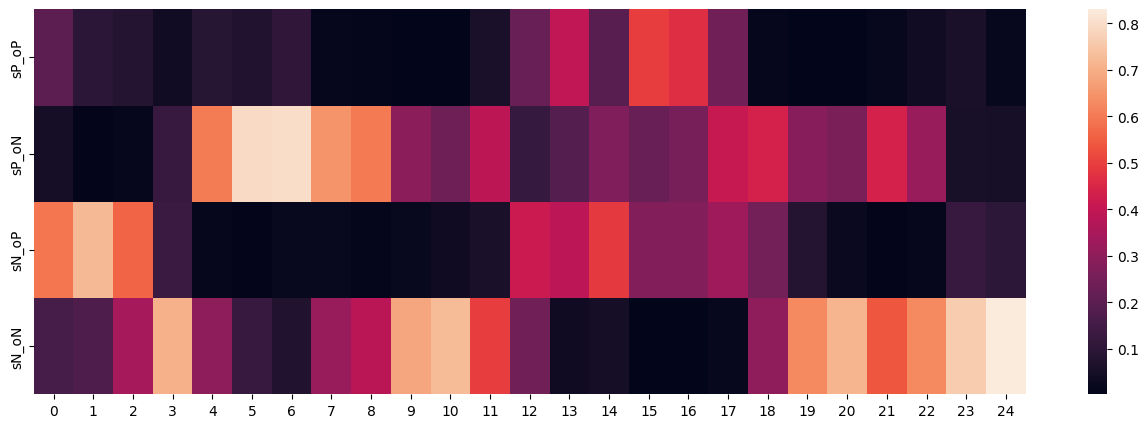

In [10]:
# plot simulated context beliefs for a single experimental condition and simulated subject
import seaborn as sns

labels = {
    0: "s_pos_o_zer",
    1: "s_neg_o_zer",
    2: "s_zer_o_pos",
    3: "s_zer_o_neg",
    4: "s_zer_o_zer",
}

n_block = 0
n_subject = 0

plt.figure(figsize=(16, 5))
sns.heatmap(samples["beliefs"][0][0][n_block, n_subject].T)
plt.yticks([0.5, 1.5, 2.5, 3.5], labels=agency_names)

exp_condition = samples["states"][-1][0][0]

print(labels[exp_condition[n_block, n_subject].item()])

In [11]:
# compute rating of self or other control at the end of experimental block, based on
# final beliefs about different contexts (experimental conditions)
exp_condition = samples["states"][-1][0][0]
last_beliefs_about_condition = samples["beliefs"][0][..., -1, :]

self_rating = (
    last_beliefs_about_condition[0, ..., 0]
    + last_beliefs_about_condition[0, ..., 1]
    - last_beliefs_about_condition[0, ..., 2]
    - last_beliefs_about_condition[0, ..., 3]
)

other_rating = (
    last_beliefs_about_condition[0, ..., 0]
    + last_beliefs_about_condition[0, ..., 2]
    - last_beliefs_about_condition[0, ..., 1]
    - last_beliefs_about_condition[0, ..., 3]
)

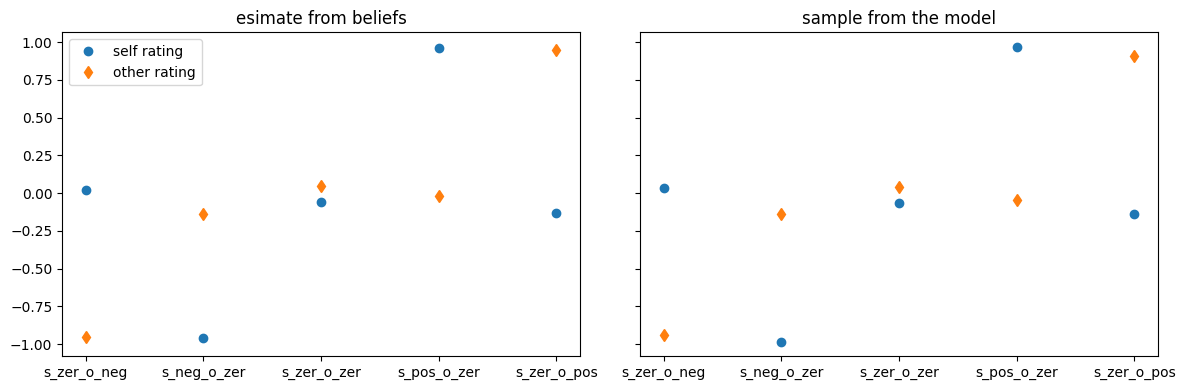

In [12]:
# visualise ratings either computed using context beliefs or directly sampled
# from the auxuliary components of the likelihood

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

smpl_other_rating = samples["aux_other"][0, ..., -1]
smpl_self_rating = samples["aux_self"][0, ..., -1]

x = []
y1 = []
y2 = []
smpl_y1 = []
smpl_y2 = []
for i in [3, 1, 4, 0, 2]:
    loc = exp_condition == i
    x.append(labels[i])
    y1.append(self_rating[loc].mean())
    y2.append(other_rating[loc].mean())

    smpl_y1.append(smpl_self_rating[loc].mean())
    smpl_y2.append(smpl_other_rating[loc].mean())

axes[0].plot(x, y1, "o", label="self rating")
axes[0].plot(x, y2, "d", label="other rating")

axes[1].plot(x, smpl_y1, "o", label="self rating")
axes[1].plot(x, smpl_y2, "d", label="other rating")

axes[0].set_title("esimate from beliefs")
axes[1].set_title("sample from the model")

axes[0].legend()
fig.tight_layout()

### Parameter recovery with simulated behaviour

Here we will demonstrate that the model parameters are recoverable, 
if one simulates the behavior using the paramatric generative model 
of the active inference agents, and then inverts the model using the 
simulated responses. Bellow we illustrate that all of the 8 parameters 
are well recoverable, as the estimated means fall along the axis that 
follows true parameter values. 

{'seed': 101, 'enumerate': False, 'iter_steps': 1000, 'optim': None, 'optim_kwargs': {'learning_rate': 0.001}, 'elbo_kwargs': {'num_particles': 10, 'max_plate_nesting': 1}, 'svi_kwargs': {'progress_bar': True, 'stable_update': True}, 'sample_kwargs': {'num_samples': 100}}


100%|██████████| 1000/1000 [20:52<00:00,  1.25s/it, init loss: 33002.4258, avg. loss [951-1000]: 15605.3447]


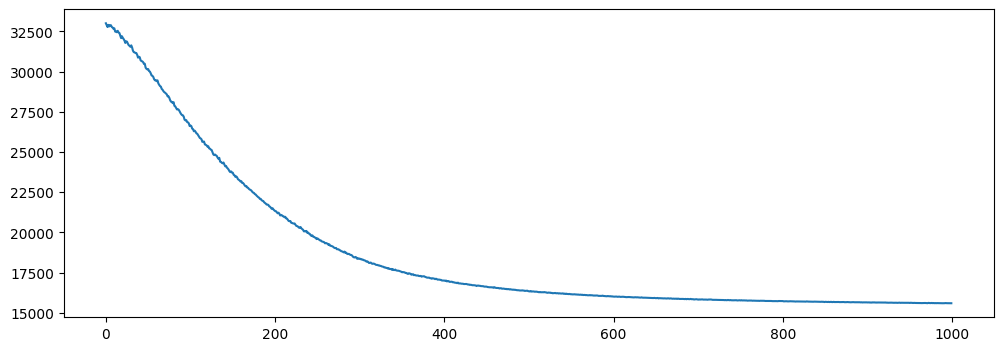

In [13]:
measurments = {
    "outcomes": [outcomes[0] for outcomes in samples["outcomes"]],
    "multiactions": samples["multiactions"][0],
    "multiaction_cat": samples["multiaction_cat"][0],
    "auxiliary_actions": [
        samples["aux_self"][0],
        samples["aux_other"][0],
    ],
}

model = NumpyroModel(prior, transform, likelihood, opts=opts_model)
posterior = NumpyroGuide(NormalPosterior(num_params, num_agents, backend="numpyro"))

# perform inference using stochastic variational inference
opts_svi = default_dict_numpyro_svi | {"iter_steps": 1000, "seed": 101}
print(opts_svi)

svi_samples, svi, results = run_svi(model, posterior, measurments, opts=opts_svi)
plt.figure(figsize=(12, 4))
plt.plot(results.losses)

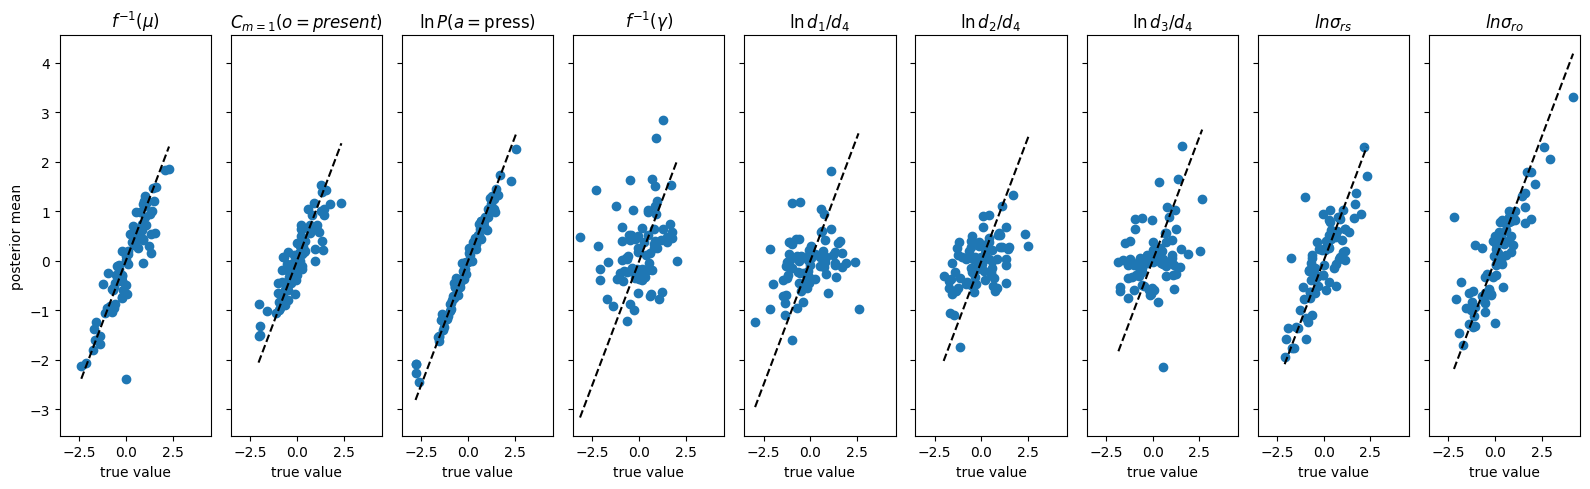

In [14]:
param_label = [
    r"$f^{-1}(\mu)$",
    r"$C_{m=1}(o=present)$",
    r"$\ln P(a=\text{press})$",
    r"$f^{-1}(\gamma)$",
    r"$\ln d_1/d_4$",
    r"$\ln d_2/d_4$",
    r"$\ln d_3/d_4$",
    r"$ln \sigma_{rs}$",
    r"$ln \sigma_{ro}$",
]
z = samples["z"][0]
fig, axes = plt.subplots(1, z.shape[-1], figsize=(16, 5), sharex=True, sharey=True)

for i in range(z.shape[-1]):
    axes[i].scatter(z[:, i], svi_samples["z"].mean(0)[:, i], label=i)
    axes[i].plot((z[:, i].min(), z[:, i].max()), (z[:, i].min(), z[:, i].max()), "k--")
    axes[i].set_xlabel("true value")
    axes[i].set_title(param_label[i])

axes[0].set_ylabel("posterior mean")
fig.tight_layout()

## Fitting behavioural data

In [15]:
import pandas as pd

exp_data = pd.read_csv("behavioural_data_agency.csv")

outcomes = [[], [], []]
multiactions = []
ratings = [[], []]
group = []
for pid in exp_data.PID.unique():
    df = exp_data.loc[exp_data.PID == pid].pivot(
        index=["block_num"],
        columns=["timesteps"],
        values=[
            "outcome",
            "action_self",
            "action_other",
            "rating_self",
            "rating_other",
        ],
    )
    group.append(exp_data.loc[exp_data.PID == pid].depgroup.unique().item())
    outcomes[0].append(jnp.array(df.outcome.values))
    outcomes[1].append(jnp.array(df.action_self.values))
    outcomes[2].append(jnp.array(df.action_other.values))

    ratings[0].append(jnp.array(df.rating_self.values))

    ratings[1].append(jnp.array(df.rating_other.values))

    for o in outcomes:
        if jnp.any(jnp.isnan(o[-1])):
            print(pid)

    multiactions.append(outcomes[1][-1])


# set "nondep" as 0, and "dep" as 1
dep_group = jnp.array([False if g == "nondep" else True for g in group])

outcomes = [jnp.pad(jnp.stack(o, 1), [(0, 0), (0, 0), (1, 0)]) for o in outcomes]
multiactions = jnp.pad(
    jnp.stack(multiactions, 1)[..., None], [(0, 0), (0, 0), (0, 0), (1, 1)]
)

ratings = [jnp.stack(r, 1) / 100 for r in ratings]
exp_measurments = {
    "outcomes": outcomes,
    "multiactions": multiactions,
    "auxiliary_actions": ratings,
}

opts_task = {
    "num_blocks": multiactions.shape[0],
    "num_trials": multiactions.shape[-2],
    "num_agents": multiactions.shape[1],
    "record_agent": False,
}

opts_model = {"prior": {}, "transform": {}, "likelihood": opts_task}

In [16]:
def plot_results(samples):
    param_label = [
        r"$f^{-1}(\mu)$",
        r"$C_{m=1}(o=present)$",
        r"$\ln P(a=\text{press})$",
        r"$f^{-1}(\gamma)$",
        r"$\ln d_1/d_4$",
        r"$\ln d_2/d_4$",
        r"$\ln d_3/d_4$",
        r"$ln \sigma_{rs}$",
        r"$ln \sigma_{ro}$",
    ]

    fig, axes = plt.subplots(1, num_params, figsize=(16, 5), sharex=True, sharey=True)
    grp = jnp.array([0 if g == "nondep" else 1 for g in group])
    dep = grp == 1
    for i in range(num_params):
        sns.stripplot(samples["z"].mean(0)[~dep, i], ax=axes[i], label="nondep")
        sns.stripplot(samples["z"].mean(0)[dep, i], ax=axes[i], label="dep")
        axes[i].set_title(param_label[i])

    axes[0].legend(title="group")
    axes[0].set_ylabel("value")
    fig.tight_layout()


def plot_results2(samples):
    param_label = [
        r"$\mu$",
        r"$C_{m=1}(o=present)$",
        r"$P(a=\text{press})$",
        r"$\gamma$",
        r"$d_1/d_4$",
        r"$d_2/d_4$",
        r"$d_3/d_4$",
        r"$\sigma_{rs}$",
        r"$\sigma_{ro}$",
    ]

    D0 = jnp.mean(samples["D"][0][..., :-1] / samples["D"][0][..., -1:], 0)

    fig, axes = plt.subplots(2, (num_params + 1) // 2, figsize=(16, 5), sharex=True)
    axes = axes.flatten()
    grp = jnp.array([0 if g == "nondep" else 1 for g in group])
    dep = grp == 1
    for i in range(num_params):
        if param_label[i] == r"$\mu$":
            sns.stripplot(
                samples["expected_outcome"].mean(0)[~dep], ax=axes[i], label="nondep"
            )
            sns.stripplot(
                samples["expected_outcome"].mean(0)[dep], ax=axes[i], label="dep"
            )
        elif param_label[i] == r"$C_{m=1}(o=present)$":
            sns.stripplot(
                samples["outcome_pref"].mean(0)[~dep], ax=axes[i], label="nondep"
            )
            sns.stripplot(samples["outcome_pref"].mean(0)[dep], ax=axes[i], label="dep")

        elif param_label[i] == r"$P(a=\text{press})$":
            sns.stripplot(samples["E"].mean(0)[~dep, 1], ax=axes[i], label="nondep")
            sns.stripplot(samples["E"].mean(0)[dep, 1], ax=axes[i], label="dep")
        elif param_label[i] == r"$\gamma$":
            sns.stripplot(samples["gamma"].mean(0)[~dep], ax=axes[i], label="nondep")
            sns.stripplot(samples["gamma"].mean(0)[dep], ax=axes[i], label="dep")
        elif "d_4" in param_label[i]:
            sns.stripplot(D0[~dep, i - 4], ax=axes[i], label="nondep")
            sns.stripplot(D0[dep, i - 4], ax=axes[i], label="dep")
        elif param_label[i] == r"$\sigma_{rs}$":
            sns.stripplot(
                samples["scale_self"].mean(0)[0, ~dep], ax=axes[i], label="nondep"
            )
            sns.stripplot(
                samples["scale_self"].mean(0)[0, dep], ax=axes[i], label="dep"
            )
        elif param_label[i] == r"$\sigma_{ro}$":
            sns.stripplot(
                samples["scale_other"].mean(0)[0, ~dep], ax=axes[i], label="nondep"
            )
            sns.stripplot(
                samples["scale_other"].mean(0)[0, dep], ax=axes[i], label="dep"
            )

        axes[i].set_title(param_label[i])

    axes[0].legend(title="group")
    axes[0].set_ylabel("value")
    fig.tight_layout()

First we will fit the data using a simple flat prior over model parameters, where each uncostrained values of each parameter (before transform) are sampled from a standard noraml distribution. 

100%|██████████| 2000/2000 [38:25<00:00,  1.15s/it, init loss: 93452.9609, avg. loss [1901-2000]: 21994.9141]


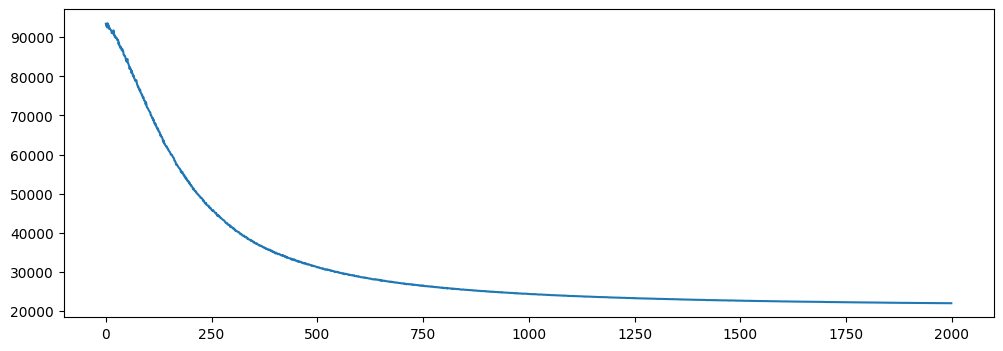

In [17]:
prior = Normal(num_params, num_agents, backend="numpyro")
model = NumpyroModel(prior, transform, likelihood, opts=opts_model)

posterior = NumpyroGuide(NormalPosterior(num_params, num_agents, backend="numpyro"))

# perform inference using stochastic variational inference
opts_svi = default_dict_numpyro_svi | {"iter_steps": 2000, "seed": 1123567}
svi_samples1, svi1, results1 = run_svi(model, posterior, exp_measurments, opts=opts_svi)

plt.figure(figsize=(12, 4))
plt.plot(results1.losses)

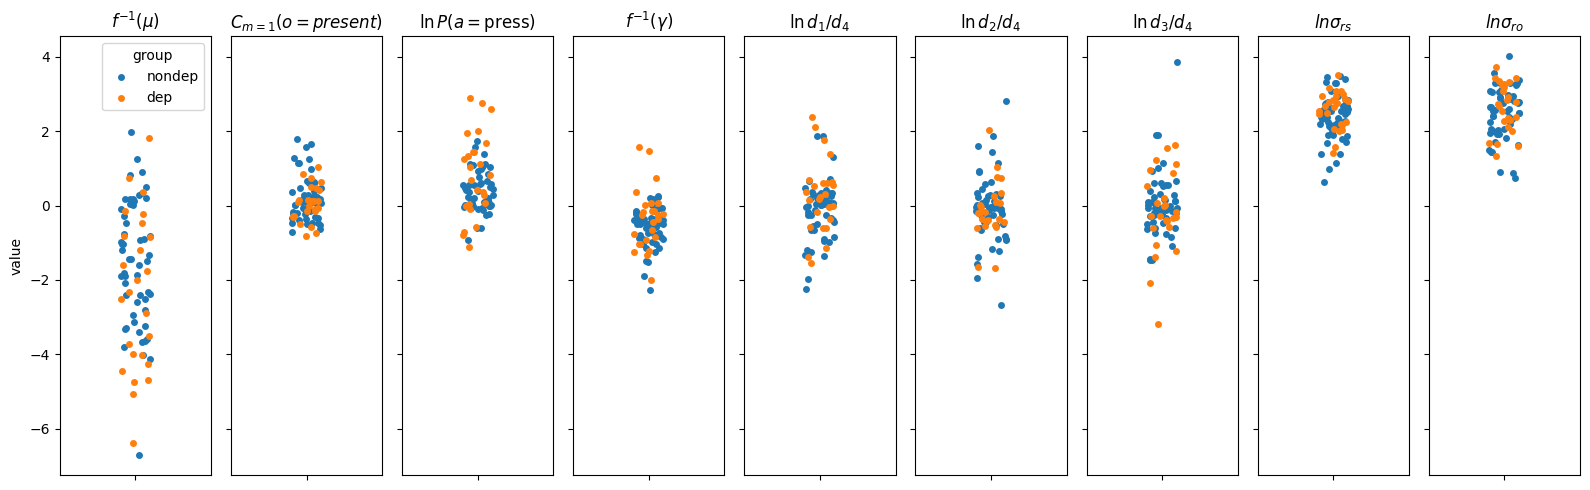

In [18]:
plot_results(svi_samples1)

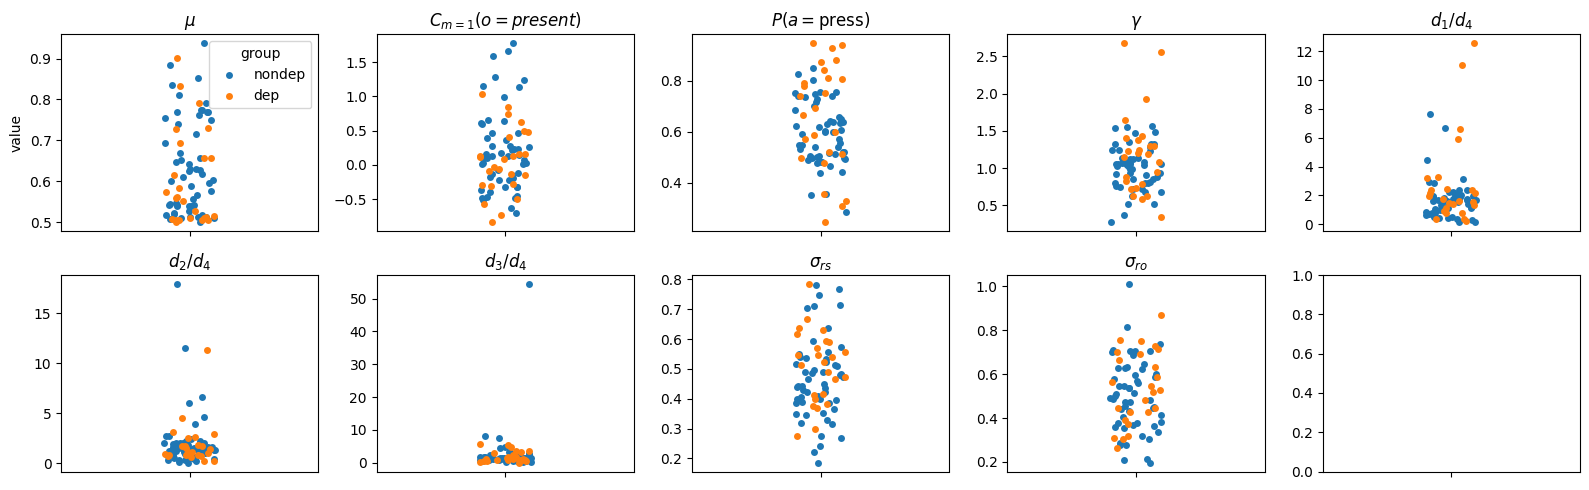

In [19]:
# we can also plot parameters in constrained space
plot_results2(svi_samples1)

In [20]:
# simulating behaviour from posterior samples

opts_task = {
    "task": agency_task,
    "num_blocks": num_blocks,
    "num_trials": num_timesteps,
    "num_agents": num_agents,
    "record_agent": False,  # setting this to true creates an 'init_agent' and 'agent_sequence' variable in samples (posterior or prior samples)
}
opts_model = {"prior": {}, "transform": {}, "likelihood": opts_task}

prior = Normal(num_params, num_agents, backend="numpyro")
model = NumpyroModel(prior, transform, likelihood, opts=opts_model)

pred = Predictive(model, guide=posterior, params=results1.params, num_samples=1)
key, _key = jr.split(key)
post_pred_samples = pred(_key)

In [21]:
post_pred_samples.keys()

dict_keys(['D', 'E', 'aux_other', 'aux_self', 'beliefs', 'expected_outcome', 'gamma', 'multiaction_cat', 'multiaction_probs', 'multiactions', 'outcome_pref', 'outcomes', 'scale_other', 'scale_self', 'states'])

As a second example we will fit the data using the NormalGamma prior over unconstrained parameter values, where one infers prior uncertainty on a group level for each parameter. 

100%|██████████| 2000/2000 [38:35<00:00,  1.16s/it, init loss: 61380.3945, avg. loss [1901-2000]: 20601.4160]


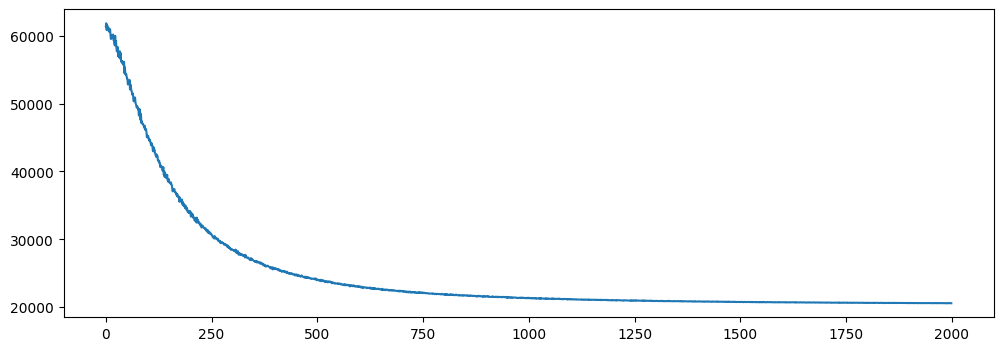

In [22]:
prior = NormalGamma(num_params, num_agents, backend="numpyro")
model = NumpyroModel(prior, transform, likelihood, opts=opts_model)

posterior = NumpyroGuide(
    NormalGammaPosterior(num_params, num_agents, backend="numpyro")
)

# perform inference using stochastic variational inference
opts_svi = default_dict_numpyro_svi | {"iter_steps": 2000, "seed": 197823476}
svi_samples2, svi2, results2 = run_svi(model, posterior, exp_measurments, opts=opts_svi)

plt.figure(figsize=(12, 4))
plt.plot(results2.losses)

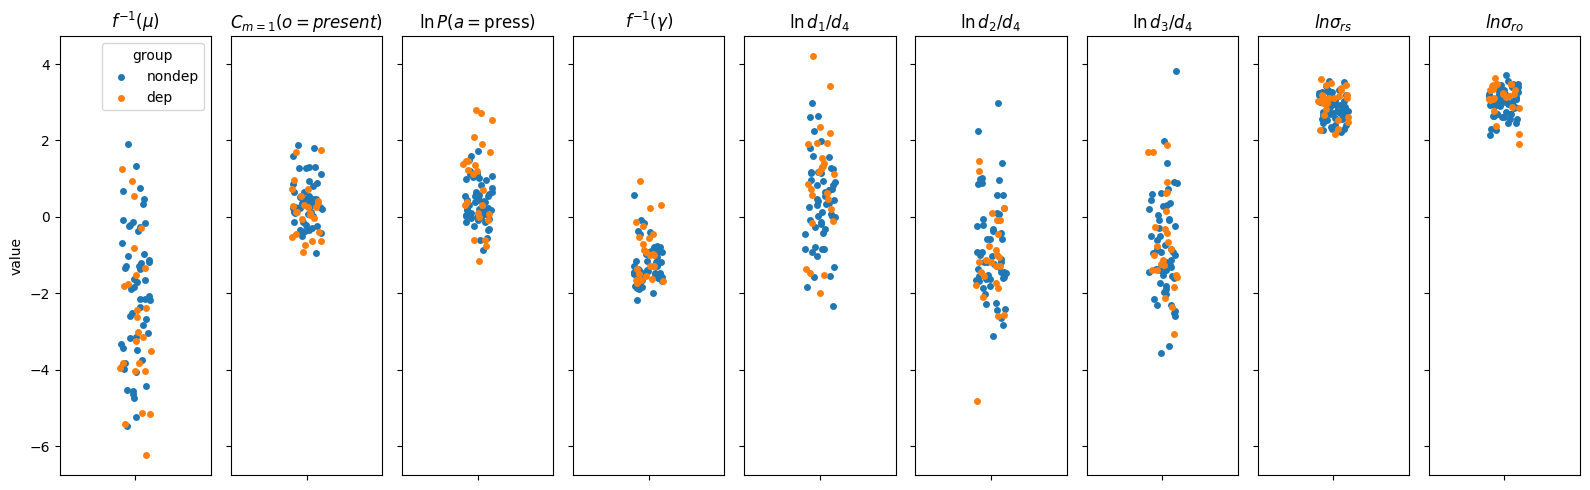

In [23]:
plot_results(svi_samples2)

As a final exmaple we will fit the data using the RegularisedHorseshoe prior over unconstrained parameter values. This prior puts a lots of a priory wait on group mean, as an only relevant parameter, hence it has a strong pulling effect between participants, which can help to estimate corretly group level mean, when the experimental data do not contain sufficient information about specific parameter value on a single subject level.

100%|██████████| 2000/2000 [38:19<00:00,  1.15s/it, init loss: 61047.1016, avg. loss [1901-2000]: 20459.4141]


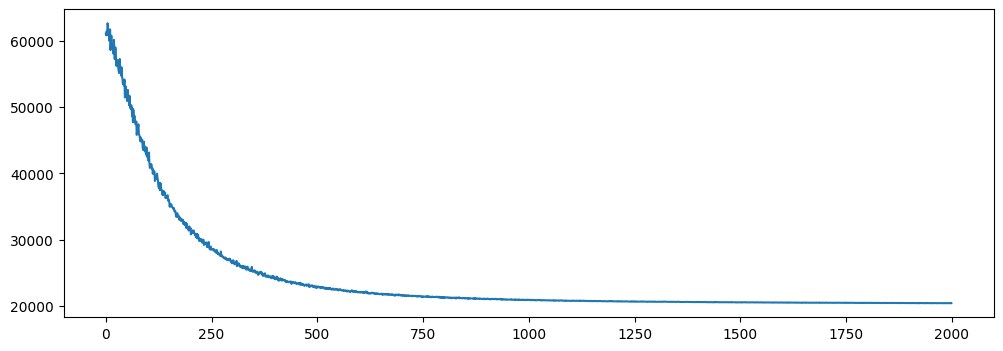

In [24]:
prior = RegularisedHorseshoe(num_params, num_agents, backend="numpyro")
model = NumpyroModel(prior, transform, likelihood, opts=opts_model)

posterior = NumpyroGuide(
    RegularisedHorseshoePosterior(num_params, num_agents, backend="numpyro")
)

# perform inference using stochastic variational inference
opts_svi = default_dict_numpyro_svi | {"iter_steps": 2000, "seed": 623342}
svi_samples3, svi3, results3 = run_svi(model, posterior, exp_measurments, opts=opts_svi)

plt.figure(figsize=(12, 4))
plt.plot(results3.losses)

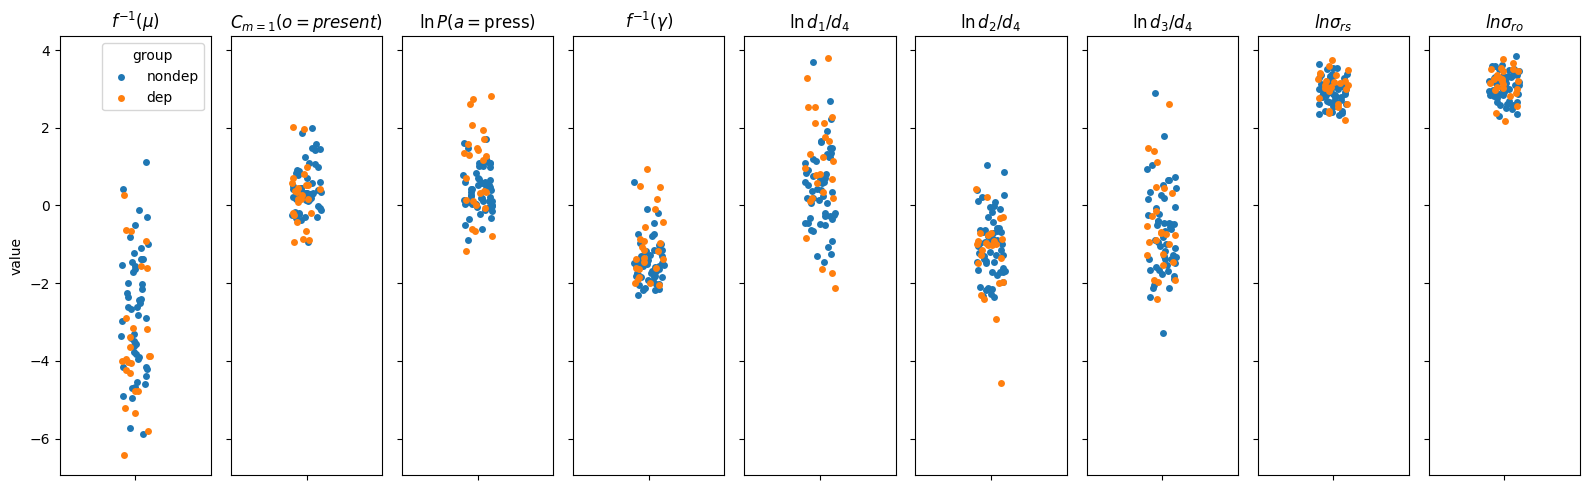

In [25]:
plot_results(svi_samples3)

100%|██████████| 2000/2000 [21:14<00:00,  1.57it/s, init loss: 23024.9551, avg. loss [1901-2000]: 5810.0825]


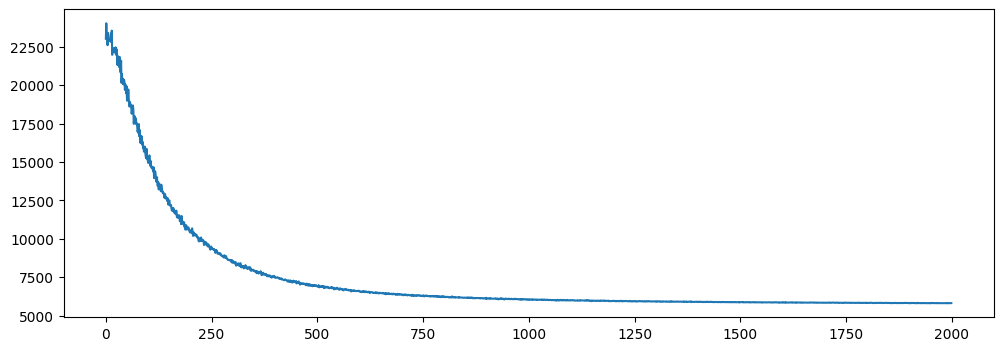

In [26]:
# fit depressed
dep_data = jtu.tree_map(lambda x: x[:, dep_group], exp_measurments)
num_dep_agents = dep_group.sum().item()
opts_task["num_agents"] = num_dep_agents

opts_model = {"prior": {}, "transform": {}, "likelihood": opts_task}

prior = RegularisedHorseshoe(num_params, num_dep_agents, backend="numpyro")
model = NumpyroModel(prior, transform, likelihood, opts=opts_model)

posterior = NumpyroGuide(
    RegularisedHorseshoePosterior(num_params, num_dep_agents, backend="numpyro")
)

# perform inference using stochastic variational inference
opts_svi = default_dict_numpyro_svi | {"iter_steps": 2000, "seed": 6242}
svi_samples_dep, svi_dep, results_dep = run_svi(
    model, posterior, dep_data, opts=opts_svi
)

plt.figure(figsize=(12, 4))
plt.plot(results_dep.losses)

100%|██████████| 2000/2000 [32:20<00:00,  1.03it/s, init loss: 38115.0508, avg. loss [1901-2000]: 14698.1787]


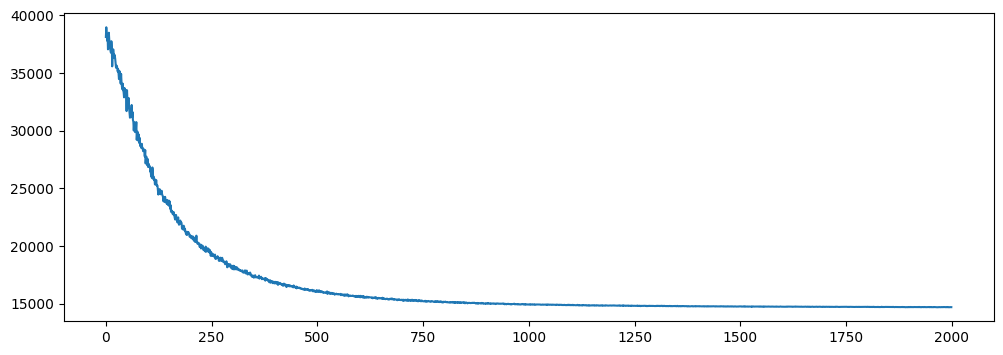

In [27]:
# fit non-depressed
dep_data = jtu.tree_map(lambda x: x[:, ~dep_group], exp_measurments)
num_nondep_agents = num_agents - dep_group.sum().item()
opts_task["num_agents"] = num_nondep_agents

opts_model = {"prior": {}, "transform": {}, "likelihood": opts_task}

prior = RegularisedHorseshoe(num_params, num_nondep_agents, backend="numpyro")
model = NumpyroModel(prior, transform, likelihood, opts=opts_model)

posterior = NumpyroGuide(
    RegularisedHorseshoePosterior(num_params, num_nondep_agents, backend="numpyro")
)

# perform inference using stochastic variational inference
opts_svi = default_dict_numpyro_svi | {"iter_steps": 2000, "seed": 3342}
svi_samples_nondep, svi_nondep, results_nondep = run_svi(
    model, posterior, dep_data, opts=opts_svi
)

plt.figure(figsize=(12, 4))
plt.plot(results_nondep.losses)

In [28]:
# group mean and uncertainty in unconstrained parameter space
print("dep: ", svi_samples_dep["mu"].mean(0))
print(
    "dep: ",
    svi_samples_dep["mu"].var(0) + jnp.mean(svi_samples_dep["sigma"] ** 2, axis=0),
)

print("non-dep: ", svi_samples_nondep["mu"].mean(0))
print(
    "non-dep: ",
    svi_samples_nondep["mu"].var(0)
    + jnp.mean(svi_samples_nondep["sigma"] ** 2, axis=0),
)

dep:  [-2.1106014   0.0429716   0.80096424  0.34041148  1.0883331  -0.4783911
 -0.34822726  1.6115948   1.6297363 ]
dep:  [3.9021697 0.483746  1.739516  3.1367145 3.7203171 3.7476432 3.6695068
 3.3052537 3.410961 ]
non-dep:  [-1.2927477   0.68487847  0.3943579  -1.9189569  -0.12379749 -0.69199127
 -1.2206947   1.5709436   1.6640376 ]
non-dep:  [3.5278895 1.2444165 0.3626493 0.7508144 3.1636596 3.2185488 3.3763316
 2.8895411 2.9426146]
